In [1]:
import numpy as np
import pandas as pd
from ord_data_load import ORD_PATH, df_na_vals, fahrenheit_to_celsius
from chem_render import draw_reaction

from matplotlib import pyplot as plt

#to disable warnings
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%load_ext autoreload
%autoreload 2

# 1. Inspect REACTIONS dataset

In [2]:
%%time
df = pd.read_pickle(f"{ORD_PATH}/uspto_rxn.pkl.zst")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1770543 entries, ord-89aff4b1c18042e4bbb1f88ebba96f86 to ord-d1adc6bb76454fb9b0b4a2f30a493858
Data columns (total 9 columns):
 #   Column        Dtype   
---  ------        -----   
 0   rxn_smiles    object  
 1   time_unit     category
 2   time_val      float64 
 3   temp_unit     category
 4   temp_val      float64 
 5   temp_control  category
 6   yield         float64 
 7   patent        category
 8   notes         object  
dtypes: category(4), float64(3), object(2)
memory usage: 93.9+ MB
CPU times: total: 5.64 s
Wall time: 5.64 s


## 1.1 SMILES

In [3]:
print("Fraction of unique reaction smiles:")
df.rxn_smiles.unique().shape[0] / df.shape[0]

Fraction of unique reaction smiles:


0.6111673085601422

In [4]:
print("Fraction of unique reaction notes:")
df.notes.unique().shape[0] / df.shape[0]

Fraction of unique reaction notes:


0.7562103829164273

In [5]:
dups = df.duplicated(subset=['rxn_smiles'])
dup_smi = df.loc[dups, 'rxn_smiles'].unique()
dup_smi

array(['[C:1]([O-:13])(=[O:12])[CH2:2][C:3]([CH2:8][C:9]([O-:11])=[O:10])([C:5]([O-:7])=[O:6])[OH:4].[CH3:14][C:15]([CH3:17])=[O:16]>CO>[C:1]([O-:13])(=[O:12])[CH2:2][C:3]([CH2:8][C:9]([O-:11])=[O:10])([C:5]([O-:7])=[O:6])[OH:4].[CH3:14][C:15]([CH3:17])=[O:16].[CH3:3][OH:4] |f:3.4.5|',
       '[P:1]([O-:5])([O-:4])([O-:3])=[O:2].[Na+].[Na+].[Na+].[Cl-].[Ca+2:10].[Cl-]>O>[P:1]([O-:5])([O-:4])([O-:3])=[O:2].[Ca+2:10].[Ca+2:10].[Ca+2:10].[P:1]([O-:5])([O-:4])([O-:3])=[O:2] |f:0.1.2.3,4.5.6,8.9.10.11.12|',
       '[CH3:1][C:2]([NH:5][S:6]([C:9]1[CH:13]=[CH:12][N:11]([CH3:14])[CH:10]=1)(=[O:8])=[O:7])([CH3:4])[CH3:3].C([Li])CCC.Cl[C:21]([O:23][CH3:24])=[O:22].Cl>C1COCC1.[Au]>[CH3:4][C:2]([NH:5][S:6]([C:9]1[CH:13]=[CH:12][N:11]([CH3:14])[C:10]=1[C:21]([O:23][CH3:24])=[O:22])(=[O:8])=[O:7])([CH3:1])[CH3:3]',
       ...,
       '[Li]CCCC.Br[C:7]1[CH:8]=[CH:9][C:10]([O:13][CH2:14][CH2:15][O:16][C:17]2[C:22]([Cl:23])=[CH:21][C:20]([CH3:24])=[CH:19][C:18]=2[Cl:25])=[N:11][CH:12]=1.[CH3:26][O:27][

In [6]:
# inspect duplicates
from random import choice

df.loc[df.rxn_smiles == choice(dup_smi)]

,rxn_smiles,time_unit,time_val,temp_unit,temp_val,temp_control,yield,patent,notes
ord-237836f6190240f0bbf6090fd171ed8c,C([O:3][C:4]([C@H:6]1[C@H:10]([C:11](OCC)=[O:1...,NaN,NaN,NaN,NaN,NaN,NaN,US08741900B2,To a stirred solution of (±)-trans-pyrrolidine...
ord-57e5fb5e878546168e71a70abcdb63e0,C([O:3][C:4]([C@H:6]1[C@H:10]([C:11](OCC)=[O:1...,NaN,NaN,NaN,NaN,NaN,NaN,US08431575B2,To a stirred solution of (±)-trans-pyrrolidine...
ord-edc485f6823041cfb62360cd963d6f02,C([O:3][C:4]([C@H:6]1[C@H:10]([C:11](OCC)=[O:1...,NaN,NaN,NaN,NaN,NaN,NaN,US09045461B2,To a stirred solution of (±)-trans-pyrrolidine...


### drop duplicated smiles
we can safely drop duplicated smiles as almost all the reactions are identical in terms of parsed fields

In [7]:
%%time
df.drop_duplicates(subset=['rxn_smiles'], inplace=True)

CPU times: total: 812 ms
Wall time: 822 ms


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1082098 entries, ord-89aff4b1c18042e4bbb1f88ebba96f86 to ord-50ff38288a5a4316959b81c266f6f624
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype   
---  ------        --------------    -----   
 0   rxn_smiles    1082098 non-null  object  
 1   time_unit     534242 non-null   category
 2   time_val      534242 non-null   float64 
 3   temp_unit     264938 non-null   category
 4   temp_val      264938 non-null   float64 
 5   temp_control  268837 non-null   category
 6   yield         441806 non-null   float64 
 7   patent        1082098 non-null  category
 8   notes         1082098 non-null  object  
dtypes: category(4), float64(3), object(2)
memory usage: 57.8+ MB


## 1.2 Time

In [9]:
df.time_unit.value_counts(dropna=False)

NaN       547856
HOUR      399554
MINUTE    121659
DAY        12749
SECOND       280
Name: time_unit, dtype: int64

280


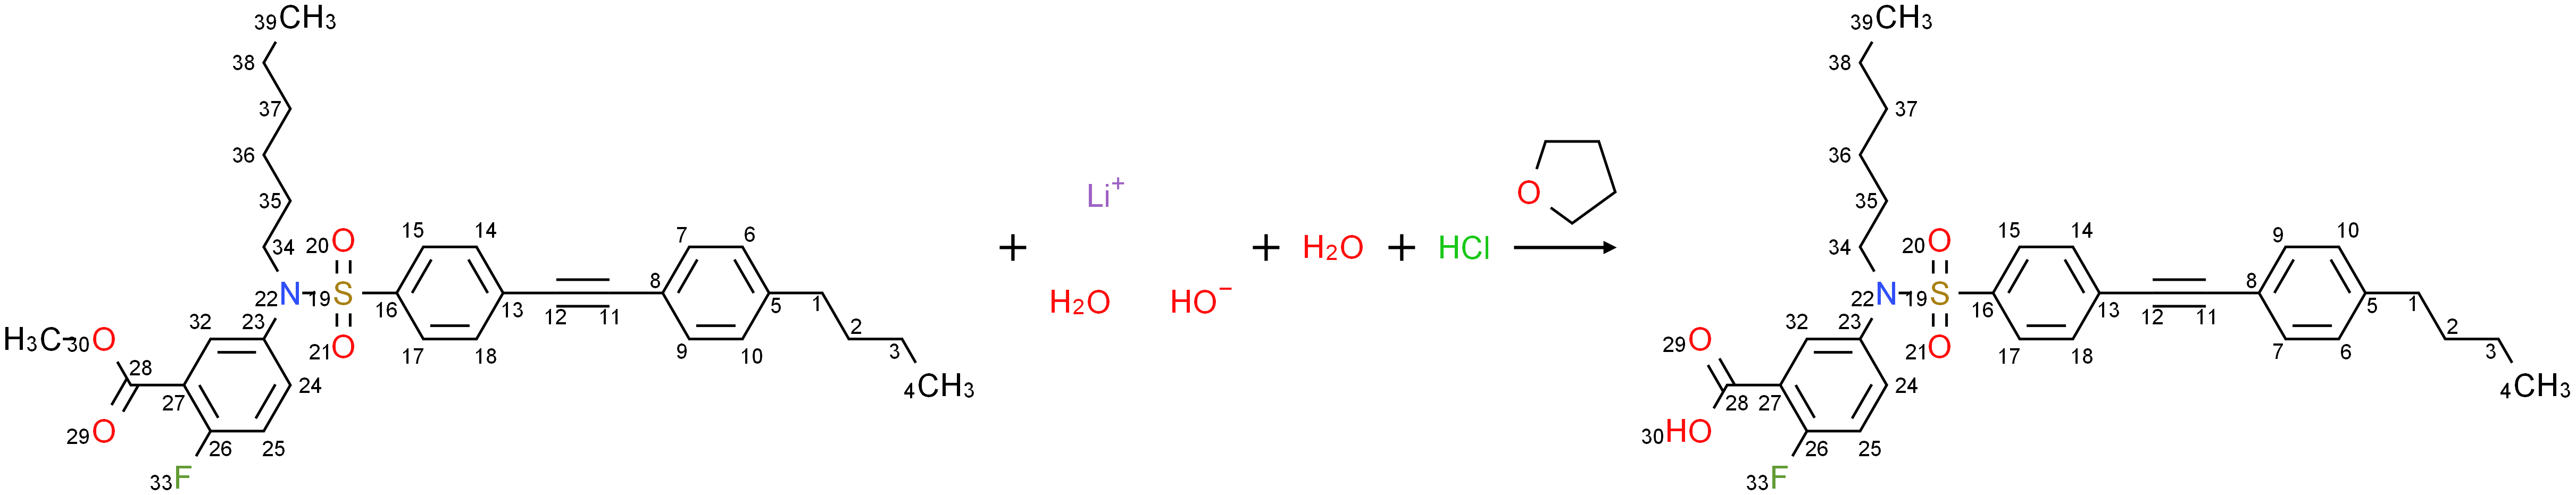

Set size:         280
Patent:           US07947851B2
Reaction_id:      ord-10920b2582104329b40d77d160cb9712
To a solution of methyl 5-[({4-[(4-butylphenyl)ethynyl]phenyl}sulfonyl)(hexyl)amino]-2-fluorobenzoate (207 mg; 0.38 mmol) in anhydrous THF (7 mL) were added lithium hydroxide monohydrate (158 mg; 3.77 mmol) and water (3 mL). The reaction mixture was stirred under MW at 100° C. for 2500 s. Then an aqueous solution of HCl (1N) was added and the mixture extracted with EtOAc (2×50 mL). The combined organic layers were washed with brine, dried over magnesium sulfate and the solvent was removed under reduced pressure to give 185 mg (91.7%) of the title compound as a brown cream. HPLC, Rt: 5.71 min (purity=98.5%). LC/MS, M−(ESI): 534.3. 1H NMR (MeOD) δ: 7.66 (d, J=8.66 Hz, 2H), 7.58 (d, J=8.66 Hz, 3H), 7.46 (d, J=7.91 Hz, 2H), 7.31. (m, 1H), 7.23 (m, 3H), 3.61 (m, 3H), 2.66 (t, J=7.53 Hz, 2H), 1.63 (qt, J=7.34 Hz, 2H), 1.35 (m, 12H), 0.96 (t, J=7.91 Hz, 3H), 0.87 (t, J=6.97 Hz, 3H).


'ord-10920b2582104329b40d77d160cb9712'

In [10]:
# seconds
print((df.time_unit == 'SECOND').sum())
draw_reaction(df[df.time_unit == 'SECOND'])

In [11]:
# convert time to HOURS

mask = df.time_unit == 'SECOND'
df.loc[mask, 'time_val'] = df.loc[mask, 'time_val'] / 3600

mask = df.time_unit == 'MINUTE'
df.loc[mask, 'time_val'] = df.loc[mask, 'time_val'] / 60

mask = df.time_unit == 'DAY'
df.loc[mask, 'time_val'] = df.loc[mask, 'time_val'] * 24

In [12]:
df.time_val.describe()

count    534242.000000
mean          8.464771
std          19.339936
min           0.000000
25%           1.000000
50%           2.500000
75%           8.000000
max        2160.000000
Name: time_val, dtype: float64

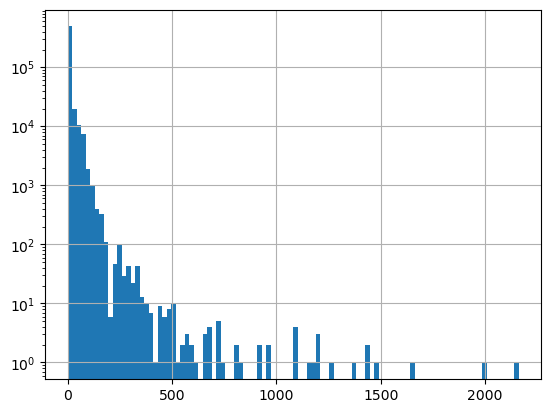

In [13]:
df.time_val.hist(bins=100)
plt.yscale('log')

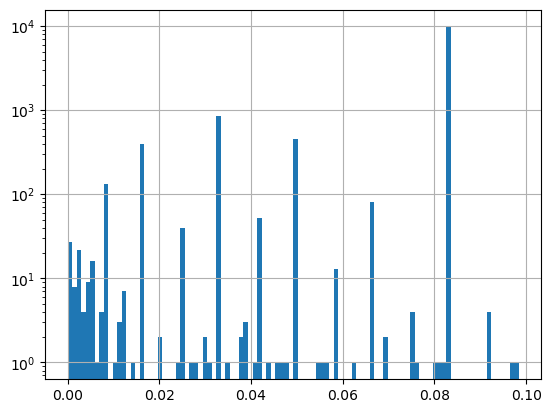

In [14]:
# inspect outliers
df[df.time_val < 0.1].time_val.hist(bins=100)
plt.yscale('log')

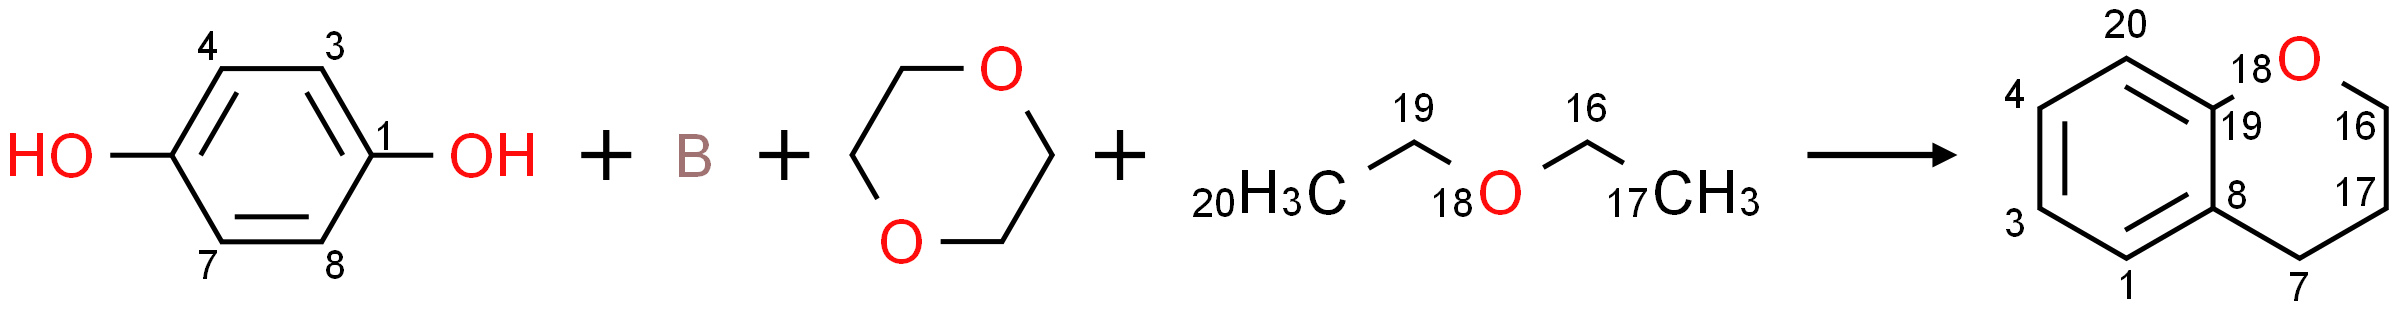

Set size:         8
Patent:           US06048891
Reaction_id:      ord-77e3cb06d0a7449cb448a45cdf4b3003
To a solution of hydroquinone 1 (0.01 mol) and a catalyst, preferably boron trifluotide diethyl etherate (0.016 mol) In an organic solvent, preferably dry dioxane (10 mL), is added vinyl lactone 2 (0.016 mol) in an organic solvent, preferably dry dioxane (5.0 mL) over 1-60 minutes, preferably 60 minutes, at 0-150° C., preferably 110° C., under an inert gas. The reaction mixture is stirred for 0 to 8 hours, preferably 0 hours, at the selected temperature, cooled to room temperature, and diluted with an organic solvent, preferably diethyl ether (200 mL) The reaction mixture is then washed with water (100 mL, 2×50 mL), dried over sodium sulfate (Na2SO4), and solvent is removed under reduced pressure to afford a brown oily residue. The residue is dissolved in alcohol, preferably methanol (30 mL), and the alcohol is then removed under reduced pressure. The brown oily liquid or semisolid i

'ord-77e3cb06d0a7449cb448a45cdf4b3003'

In [15]:
draw_reaction(df[df.time_val == 0.0])

In [16]:
df.tail()

,rxn_smiles,time_unit,time_val,temp_unit,temp_val,temp_control,yield,patent,notes
ord-25cd60edf7274f4e977451fe480d722b,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,NaN,US07968720B2,This compound was synthesized from (rac.)-(1R*...
ord-c586143a9e88422db39d951976237b09,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,NaN,US07968720B2,This compound was synthesized from (rac.)-(1R*...
ord-951218b242c246e3ac51a648e4e0c7d9,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,NaN,US07968720B2,"This compound was synthesized from (1R,5S)-7-{..."
ord-055170a7c2ee464ba733ada95c7896b8,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,NaN,US07968720B2,"This compound was synthesized from (1R,5S)-7-{..."
ord-50ff38288a5a4316959b81c266f6f624,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,NaN,US07968720B2,"This compound was synthesized from (1R,5S)-7-{..."


In [17]:
# reset to NaN time == 0.0
mask = df.time_val == 0.0
df.loc[mask, 'time_val'] = np.nan
df.loc[mask, 'time_unit'] = np.nan
df[mask]

,rxn_smiles,time_unit,time_val,temp_unit,temp_val,temp_control,yield,patent,notes
ord-f52e0b391d5149ee916861578ec96bce,[C:1]([O:5][C:6]([N:8]([C:16]1[C:21]([CH3:23])...,NaN,NaN,CELSIUS,-78.0,NaN,NaN,US09309263B2,To a dry flask was added tert-butyl N-tert-but...
ord-77e3cb06d0a7449cb448a45cdf4b3003,[C:1]1([CH:8]=[CH:7]C(O)=[CH:4][CH:3]=1)O.[B]....,NaN,NaN,NaN,NaN,AMBIENT,NaN,US06048891,To a solution of hydroquinone 1 (0.01 mol) and...
ord-91345a02d0c34481b59b0d84a51a4ac6,[C:1]1(O)[CH:6]=[CH:5]C=[CH:3][CH:2]=1.B(F)(F)...,NaN,NaN,NaN,NaN,AMBIENT,NaN,US06048891,To a solution of phenol 4 (0.01 mol) and a cat...
ord-20f38895a7c74d7ea9f6c9b0bd5016c0,[NH2:1][CH:2]1[C:19](=[O:20])[N:4]2[C:5]([C:16...,NaN,NaN,NaN,NaN,AMBIENT,66.199997,US04959495,"A mixture of 7-amino-3-[(1,2,3-thiadiazol-5-yl..."
ord-009af41175954de8b17b12067996214f,[C:1]1([CH:8]=[CH:7]C(O)=[CH:4][CH:3]=1)O.B(F)...,NaN,NaN,NaN,NaN,AMBIENT,NaN,US06242479B1,To a solution of hydroquinone 1 (0.01 mol) and...
ord-a72a83f17a1c4019962f740a6dd9f504,O1CCCC1.[C:6]([O:11][Si](C)(C)C)(=[O:10])[C:7]...,NaN,NaN,NaN,NaN,NaN,NaN,US05250109,A block copolymer of n-butyl methacrylate and ...
ord-4b6a554e34344e9587f0cb61a4875414,[C:1]1([C:32]2[CH:37]=[CH:36][CH:35]=[CH:34][C...,NaN,NaN,NaN,NaN,NaN,86.000000,US08158634B2,A solution of 2-biphenyl-4-yl-8-bromomethyl-1-...
ord-c4e60a15534d41d5931aeb64a309d73b,[C:1]([S:4][CH2:5][CH2:6][NH:7][C:8](=[O:51])[...,NaN,NaN,NaN,NaN,NaN,NaN,US07754455B2,S-acetyl CoA synthetase (acetate thiokinase fr...


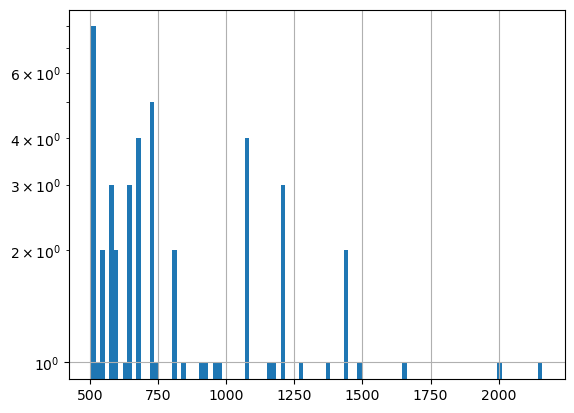

In [18]:
df.loc[df.time_val > 500, 'time_val'].hist(bins=100)
plt.yscale('log')

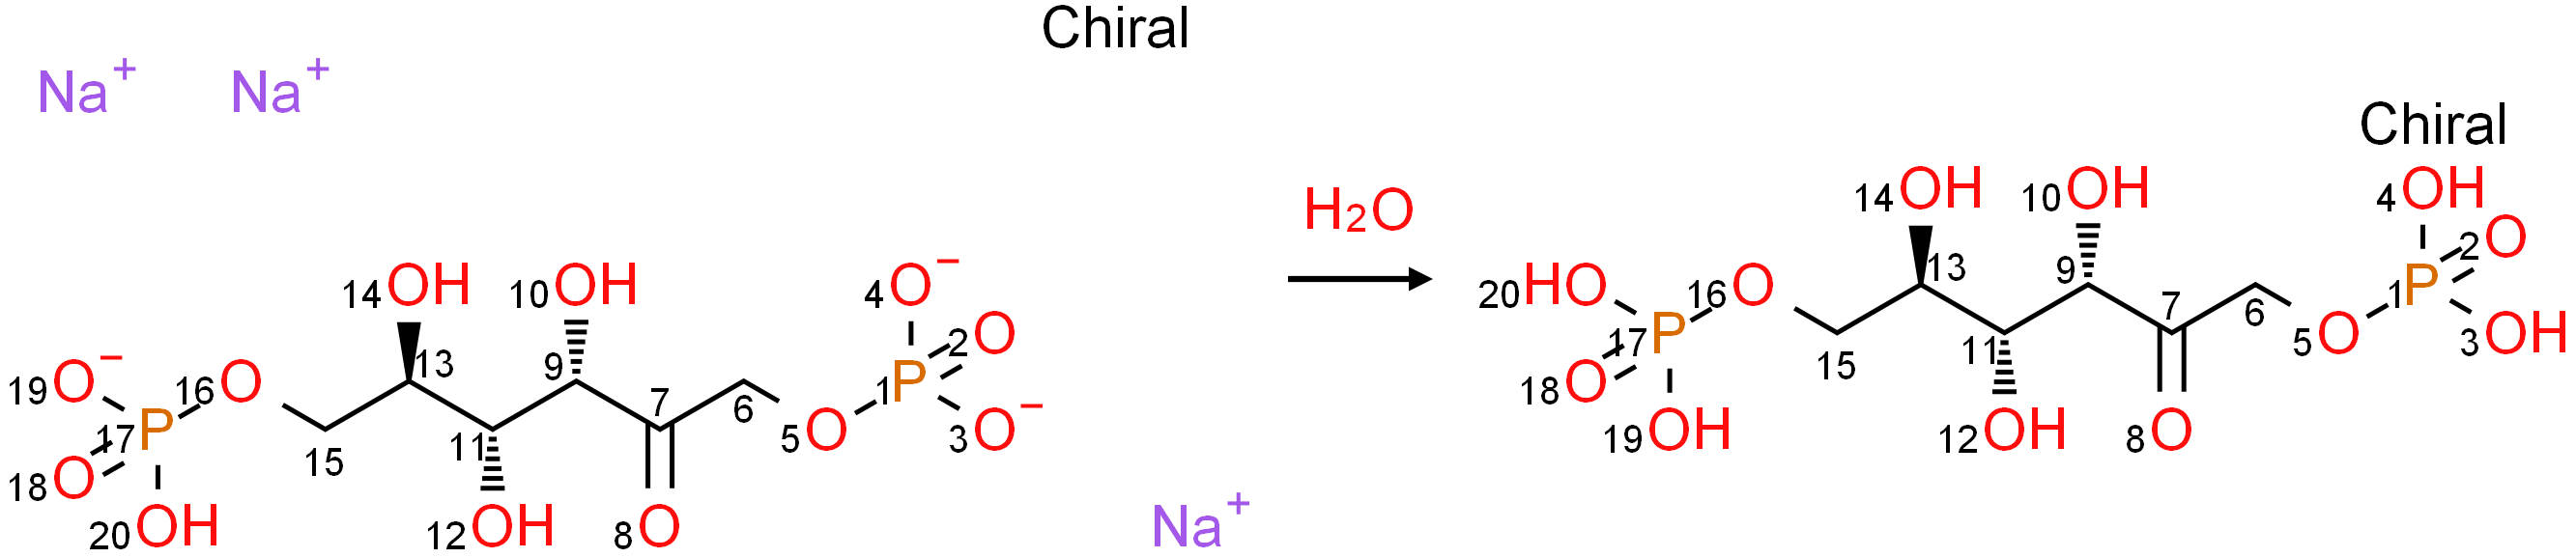

Set size:         54
Patent:           US04234499
Reaction_id:      ord-2fd69d71b32f4beb8b79d5060f8d37dc
A 5.0 gram portion of trisodium D-fructose-1,6-diphosphate was dissolved in 10 ml water. The resulting solution was added to 14.1 ml of a 0.67 M aqueous solution of cis-[Pt(NH3)2 (H2O)2 ](NO3)2. The reaction mixture was allowed to stand for 28 days in a 40° C. bath. After that time, the dark blue water-insoluble precipitate which had formed was filtered, washed with water and ethanol, and then dried in vacuum, to yield 0.566 grams of the above-identified complex.


'ord-2fd69d71b32f4beb8b79d5060f8d37dc'

In [19]:
draw_reaction(df[df.time_val > 500])

In [20]:
df.tail()

,rxn_smiles,time_unit,time_val,temp_unit,temp_val,temp_control,yield,patent,notes
ord-25cd60edf7274f4e977451fe480d722b,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,NaN,US07968720B2,This compound was synthesized from (rac.)-(1R*...
ord-c586143a9e88422db39d951976237b09,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,NaN,US07968720B2,This compound was synthesized from (rac.)-(1R*...
ord-951218b242c246e3ac51a648e4e0c7d9,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,NaN,US07968720B2,"This compound was synthesized from (1R,5S)-7-{..."
ord-055170a7c2ee464ba733ada95c7896b8,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,NaN,US07968720B2,"This compound was synthesized from (1R,5S)-7-{..."
ord-50ff38288a5a4316959b81c266f6f624,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,NaN,US07968720B2,"This compound was synthesized from (1R,5S)-7-{..."


In [21]:
# rename time 'column' and drop 'time_unit'
df.rename(columns={'time_val': 'time'}, inplace=True)
df.drop(columns='time_unit', inplace=True)
df

,rxn_smiles,time,temp_unit,temp_val,temp_control,yield,patent,notes
ord-89aff4b1c18042e4bbb1f88ebba96f86,S(Cl)([Cl:3])=O.[CH2:5]([O:13][C:14]1[CH:22]=[...,NaN,NaN,NaN,NaN,NaN,US05723069,A large excess of thionyl chloride was added t...
ord-c218088b16c541088a933a7606f68c4c,[OH:1][C:2]1[CH:10]=[CH:9][C:5]([C:6]([OH:8])=...,24.000000,NaN,NaN,NaN,NaN,US05723069,10 Grams of p-hydroxybenzoic acid and 15 g of ...
ord-d965967cbe69411f9fd760ac1f990dfb,F[C:2]1[CH:10]=[C:9]([OH:11])[CH:8]=[CH:7][C:3...,NaN,NaN,NaN,NaN,NaN,US05723069,p-Acetoxybenzoic acid was prepared in the same...
ord-e8642ae0ecb248809067cd131fde0eed,[NH2:1][C:2]1[CH:17]=[CH:16][C:5]([C:6]([NH:8]...,0.166667,CELSIUS,55.0,NaN,72.300003,US05723075,"4,4'-Diaminobenzanilide (0.658 g, 2.5 mM) was ..."
ord-83e2d9b7b08846c09e3e4e23f2dc9784,[NH2:1][C:2]1[CH:17]=[CH:16][C:5]([C:6]([NH:8]...,0.166667,CELSIUS,55.0,NaN,43.400002,US05723075,"4,4'-Diaminobenzanilide (0.568 g, 2.5 mM) was ..."
...,...,...,...,...,...,...,...,...
ord-25cd60edf7274f4e977451fe480d722b,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,US07968720B2,This compound was synthesized from (rac.)-(1R*...
ord-c586143a9e88422db39d951976237b09,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,US07968720B2,This compound was synthesized from (rac.)-(1R*...
ord-951218b242c246e3ac51a648e4e0c7d9,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,US07968720B2,"This compound was synthesized from (1R,5S)-7-{..."
ord-055170a7c2ee464ba733ada95c7896b8,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,NaN,US07968720B2,"This compound was synthesized from (1R,5S)-7-{..."


## 1.3 Temperature

In [22]:
df.temp_unit.value_counts()

CELSIUS       264876
FAHRENHEIT        57
KELVIN             5
Name: temp_unit, dtype: int64

In [23]:
mask = df.temp_unit == 'FAHRENHEIT'
id = 'ord-85dfea9f3f584c14b1e94a4cc00b506b'
df.loc[id, 'temp_val'], df.loc[mask, 'temp_val'].apply(fahrenheit_to_celsius)[id]

(230.0, 110.0)

In [24]:
mask = df.temp_unit == 'KELVIN'
df.loc[mask, 'temp_val'].apply(lambda x: x - 273.15)

ord-071609ac54774c9b8e0213c8ba4f29ff    99.85
ord-1999d9fe28034792b4b9767334223317    69.85
ord-0538fba1fd7449b78489339e8cd5fbae    69.85
ord-966a6a6fb3bf4862a268ad3bb904838c     3.35
ord-0a4ef40c7a5c499283d3f3949240aca0    49.85
Name: temp_val, dtype: float64

In [25]:
# convert everything to CELSIUS
mask = df.temp_unit == 'FAHRENHEIT'
df.loc[mask, 'temp_val'] = df.loc[mask, 'temp_val'].apply(fahrenheit_to_celsius)

mask = df.temp_unit == 'KELVIN'
df.loc[mask, 'temp_val'] = df.loc[mask, 'temp_val'].apply(lambda x: x - 273.15)

In [26]:
# rename time 'column' and drop 'time_unit'
df.rename(columns={'temp_val': 'temp'}, inplace=True)
df.drop(columns='temp_unit', inplace=True)
df

,rxn_smiles,time,temp,temp_control,yield,patent,notes
ord-89aff4b1c18042e4bbb1f88ebba96f86,S(Cl)([Cl:3])=O.[CH2:5]([O:13][C:14]1[CH:22]=[...,NaN,NaN,NaN,NaN,US05723069,A large excess of thionyl chloride was added t...
ord-c218088b16c541088a933a7606f68c4c,[OH:1][C:2]1[CH:10]=[CH:9][C:5]([C:6]([OH:8])=...,24.000000,NaN,NaN,NaN,US05723069,10 Grams of p-hydroxybenzoic acid and 15 g of ...
ord-d965967cbe69411f9fd760ac1f990dfb,F[C:2]1[CH:10]=[C:9]([OH:11])[CH:8]=[CH:7][C:3...,NaN,NaN,NaN,NaN,US05723069,p-Acetoxybenzoic acid was prepared in the same...
ord-e8642ae0ecb248809067cd131fde0eed,[NH2:1][C:2]1[CH:17]=[CH:16][C:5]([C:6]([NH:8]...,0.166667,55.0,NaN,72.300003,US05723075,"4,4'-Diaminobenzanilide (0.658 g, 2.5 mM) was ..."
ord-83e2d9b7b08846c09e3e4e23f2dc9784,[NH2:1][C:2]1[CH:17]=[CH:16][C:5]([C:6]([NH:8]...,0.166667,55.0,NaN,43.400002,US05723075,"4,4'-Diaminobenzanilide (0.568 g, 2.5 mM) was ..."
...,...,...,...,...,...,...,...
ord-25cd60edf7274f4e977451fe480d722b,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,US07968720B2,This compound was synthesized from (rac.)-(1R*...
ord-c586143a9e88422db39d951976237b09,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,US07968720B2,This compound was synthesized from (rac.)-(1R*...
ord-951218b242c246e3ac51a648e4e0c7d9,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,US07968720B2,"This compound was synthesized from (1R,5S)-7-{..."
ord-055170a7c2ee464ba733ada95c7896b8,C(OC([N:8]1[CH2:15][C@H:14]2[N:16](C(OC(C)(C)C...,NaN,NaN,NaN,NaN,US07968720B2,"This compound was synthesized from (1R,5S)-7-{..."


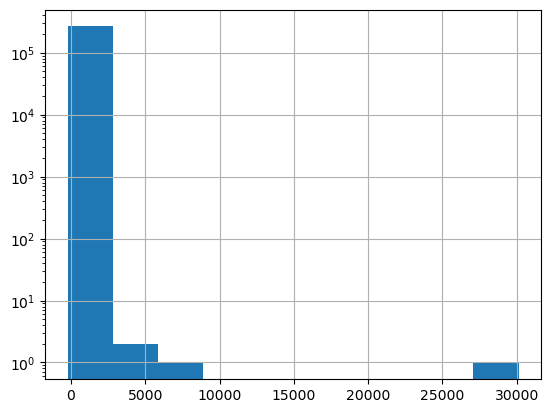

In [27]:
df.temp.hist(bins=10)
plt.yscale('log')

In [28]:
df.loc[df.temp > 25000, 'notes'].iat[0]

'1-(2-bromoethoxy)-3-fluoro-5-methylsulfonyl-benzene (0.5 g, 1.6 mmol), azetidine (0.23 ml, 3.2 mmol) and potassium carbonate (0.58 g, 4.2 mmol) was dissolved in acetonitrile (10 ml). The mixture was heated in a sealed container at 30120° C. for 2 h. The reaction mixture was cooled to room temperature, CH2Cl2 (100 ml) was added, solids was filtered off and the volatiles were evaporated. The amine was converted to the fumaric acid salt and re-crystallized from methanol/diethyl ether. MS m/z (relative intensity, 70 eV) 273 (M+, 1), 94 (5), 82 (3), 71 (5), 70 (bp).'

In [29]:
# search original patent, temperature was 120°C
df.loc[df.temp > 25000, 'temp'] = 120.0

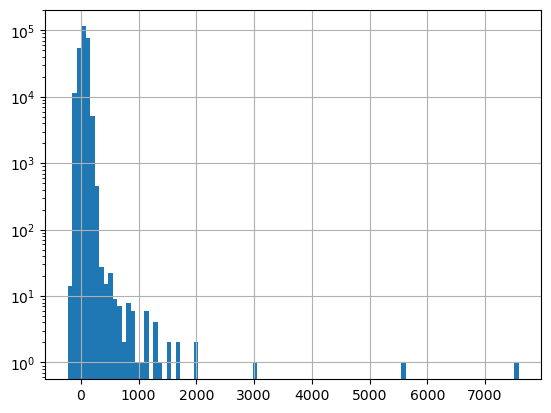

In [30]:
df.temp.hist(bins=100)
plt.yscale('log')

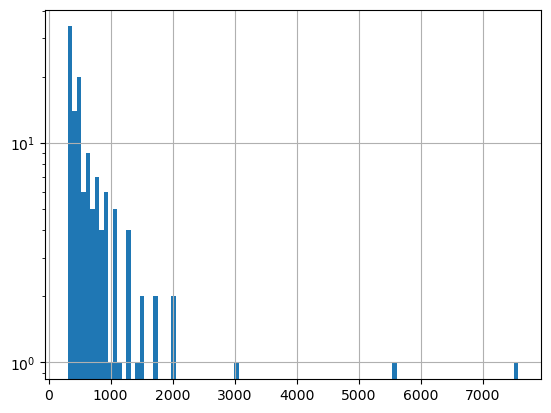

In [31]:
df.loc[df.temp > 300, 'temp'].hist(bins=100)
plt.yscale('log')

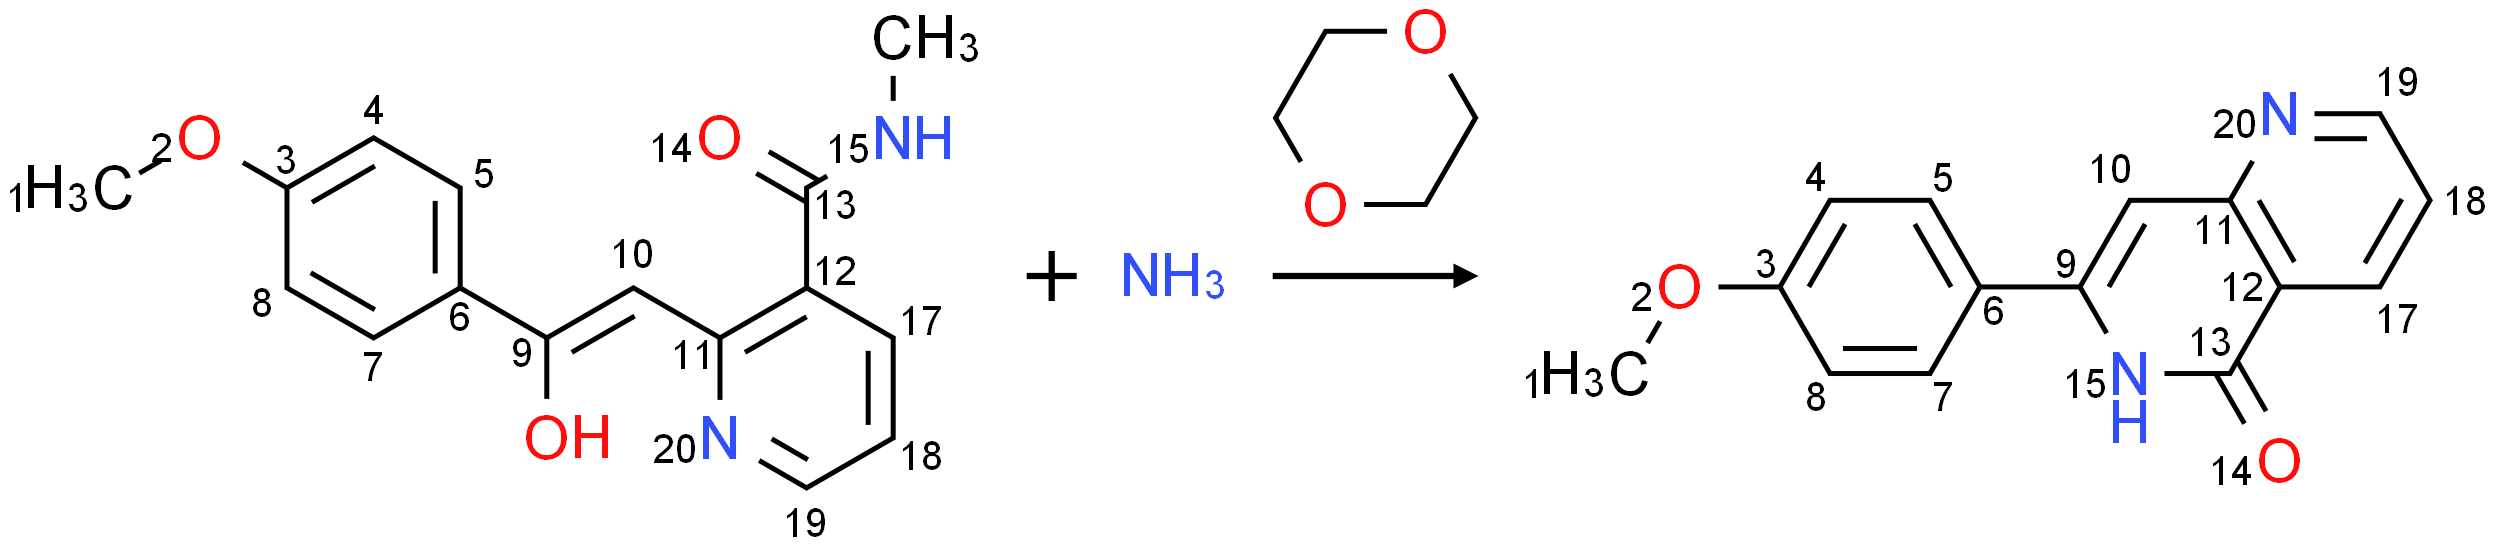

Set size:         58
Patent:           US06790844B2
Reaction_id:      ord-fbcf8fcc4b714fa39d92de8a45578b8a
2-[2-(4-Methoxyphenyl)-2-hydroxyethenyl]-N-methylnicotinamide (2.509 g) was added to a 29% aqueous solution of ammonia (100 ml) and dioxane (50 ml), which was then heated in a sealed tube at 1700° C. overnight. After cooling as it was, the resulting insoluble matters were collected by filtration, to give the title compound as a dark green solid (1.694 g, yield; 73%)


In [32]:
rxn_id = draw_reaction(df[df.temp > 500], highlight_text="° C")

In [33]:
# Temperatures 250 - 500°C seem still to be sometimes present.
# Temperatures higher than most organic reactions and should be divided by 10.
# or it can be pyrolysis, but then this reaction type is of no interest to us.
mask = df.temp > 500
df.loc[mask, 'temp'] = df.loc[mask, 'temp'] / 10

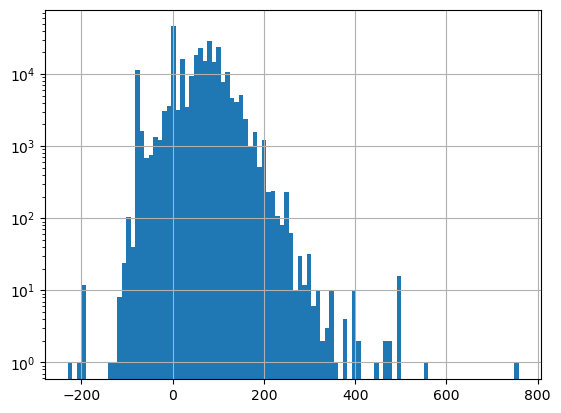

In [34]:
df.temp.hist(bins=100)
plt.yscale('log')

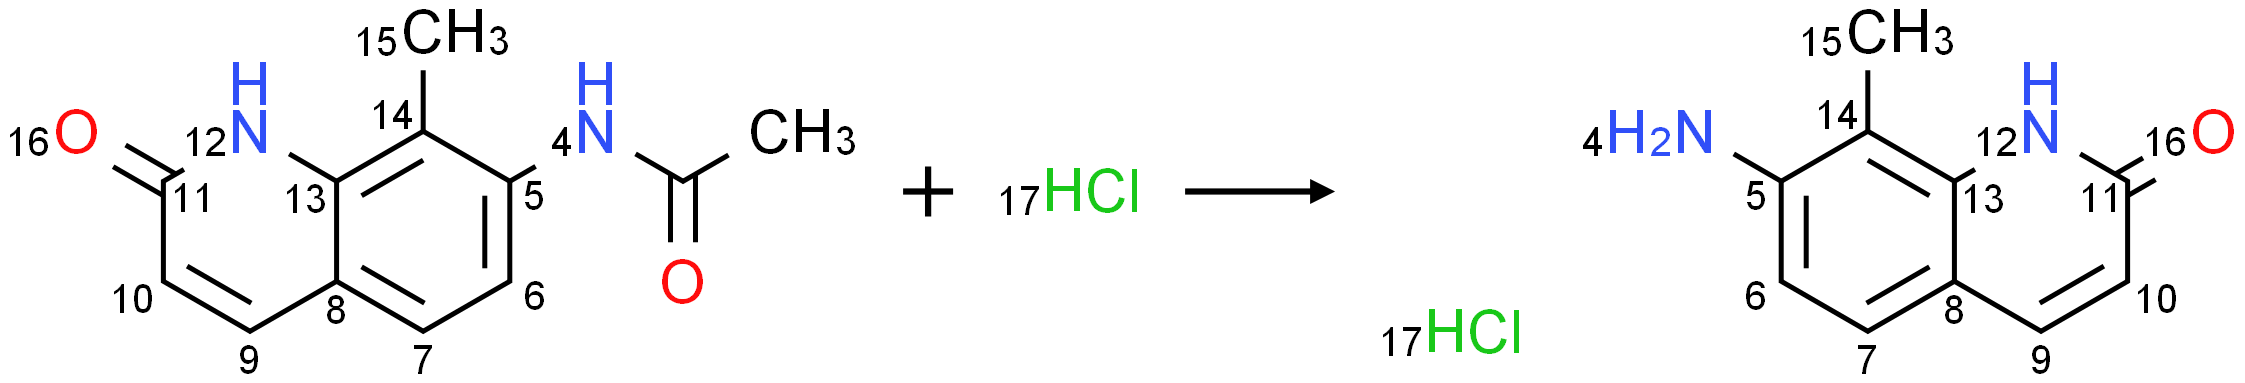

Set size:         36
Patent:           US05358949
Reaction_id:      ord-b4ea2d612bfd4f9ca3e10b68a79c846f
To 5 g of 7-acetylamino-8-methylcarbostyril was added 60 ml of 20% hydrochloric acid, and the mixture was heated at 11020 to 120° C. on an oil bath with stirring. After heating for 4 hours, the solvent was removed by evaporation under pressure, then the residue obtained was washed with hot-methanol, dried, next recrystallized from methanol-water to obtain 5.25 g of 7-amino-8-methylcarbostyril hydrochloride. Light yellow needle-like crystals. Melting point: 290°-293° C. (decomposed).


'ord-b4ea2d612bfd4f9ca3e10b68a79c846f'

In [35]:
draw_reaction(df[df.temp > 380])

In [36]:
# keep only temp nan or  < 380°C
df = df[df.temp.isna() | (df.temp < 380)]

In [37]:
df.loc[df.temp < -200]

,rxn_smiles,time,temp,temp_control,yield,patent,notes
ord-5ada0b9a1c714770b6a6937cebfd340c,C[O:2][C:3]1[CH:4]=[C:5]2[C:10](=[CH:11][C:12]...,23.0,-230.0,NaN,68.0,US05958954,"To a solution of 6-methoxy-7-fluoro-2,2-dimeth..."
ord-9989c8157da74452a4e0f0b2b520b6b2,[Cl:1][C:2]1[C:7]([F:8])=[CH:6][CH:5]=[C:4]([C...,NaN,-205.0,NaN,NaN,US08951993B2,"A mixture of 3-[1-(2,6-dichloro-3-fluoro-pheny..."


In [38]:
# quick fix of 2 mistakes
df.loc[df.temp == -230.0, 'temp'] = -23.0
df.loc[df.temp == -205, 'temp'] = 205

## 1.4 Filter by fraction of Carbon atom count

In [39]:
from chem_render import indigo

rxn_smi = df.loc['ord-e62a457d845a41ecb2e8d49c6375ba1d', 'rxn_smiles']

def carbon_ratio(rxn_smi: str) -> float:
    rxn = indigo.loadReaction(rxn_smi)
    carbon_count = 0
    total_count = 0
    for mol in rxn.iterateMolecules():
        for atom in mol.iterateAtoms():
            if atom.symbol() == 'C':
                carbon_count += 1
        total_count += mol.countAtoms()
    return carbon_count/total_count

print('carbon_ratio', carbon_ratio(rxn_smi))

carbon_ratio 0.8080808080808081


In [40]:

carbon_ratio(df.loc[rxn_id, 'rxn_smiles'])

0.7446808510638298

In [41]:
%%time
# df['c_ratio'][:1000] = df.rxn_smiles.apply(carbon_ratio)

c_ratio = df.rxn_smiles[:1000].apply(carbon_ratio)
c_ratio_approx = df.rxn_smiles[:1000].str.count(r'C(?![a-z])') / df.rxn_smiles[:1000].str.count(r'[A-GI-Z]')
# pd.concat([c_ratio, c_ratio_approx, (c_ratio - c_ratio_approx)/c_ratio > 0.01], axis=1)
any((c_ratio - c_ratio_approx)/c_ratio > 0.01)

CPU times: total: 1.14 s
Wall time: 1.14 s


False

In [42]:
%%time
c_ratio = df.rxn_smiles.str.count(r'C(?![a-z])') / df.rxn_smiles.str.count(r'[A-GI-Z]')

CPU times: total: 20.7 s
Wall time: 20.6 s


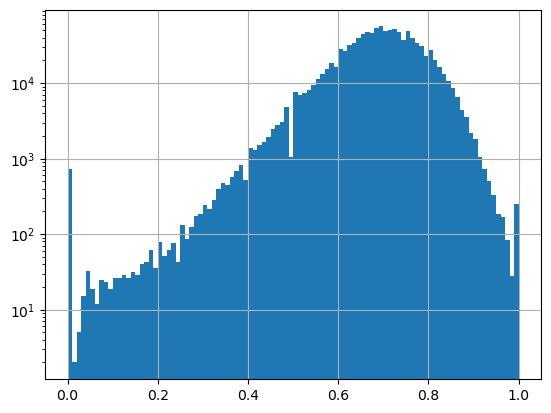

In [43]:
c_ratio.hist(bins=100)
plt.yscale('log')

In [44]:
# drop inorganic reactions
df = df[c_ratio > 0.0]

C:\Users\ergot\AppData\Local\Temp\ipykernel_25656\865991295.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  draw_reaction(df[c_ratio.between(0.0, 0.3)])


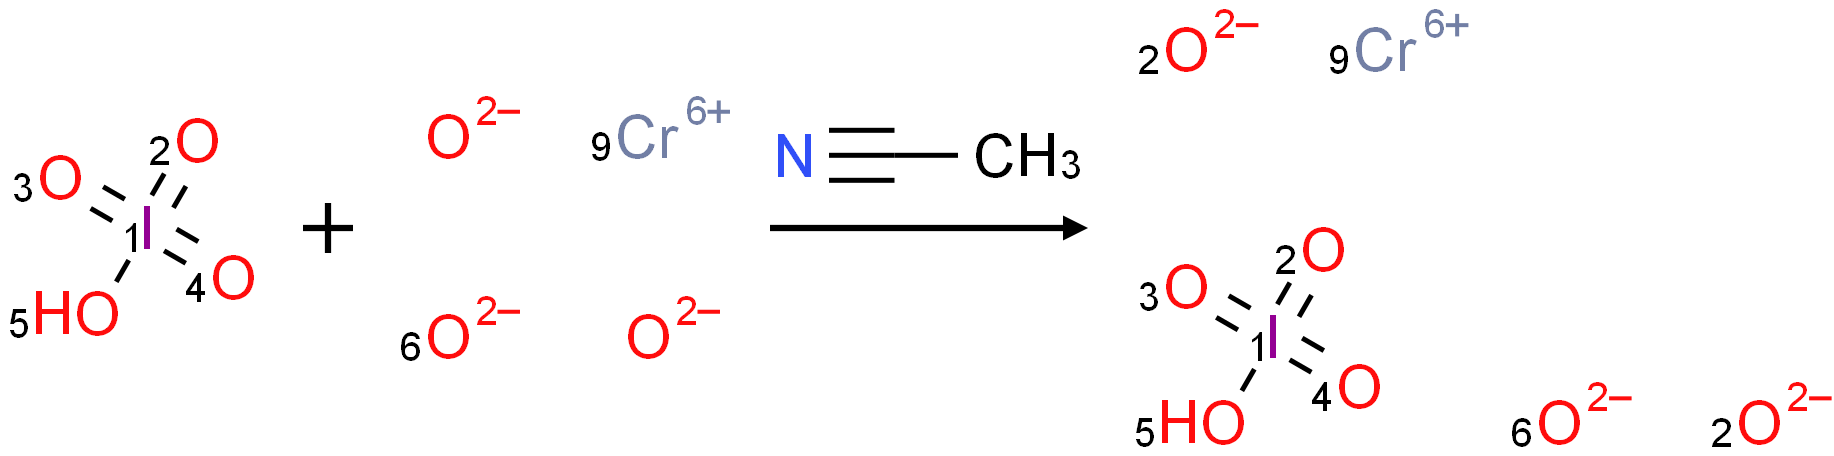

C:\Users\ergot\AppData\Local\Temp\ipykernel_25656\865991295.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[c_ratio > 0.3]


Set size:         1583
Patent:           US09284323B2
Reaction_id:      ord-d7dddfe65d0c46cd9744a94c23bf04cc
A stock solution of periodic acid/chromium trioxide was prepared according to WO 99/52850 by dissolving periodic acid (11.4 g, 50.0 mmol) and chromium trioxide (23 mg, 1.2 mol %) in wet acetonitrile (0.75% H2O) to a volume of 114 mL. To a solution of (S)-2-tert-butoxy-2-((R)-1-(2,3-dihydropyrano[4,3,2-de]quinolin-7-yl)-3,7-dimethylnaphthalen-2-yl)ethanol (211 mg) in MeCN (3 mL) was added the above stock solution (200 μL). After 2 h, the mixture was filtered and purified by reverse phase HPLC (MeCN w/0.1% TFA/H2O) to give the desired product. 1H-NMR: 400 MHz, (CD3OD) δ: 8.55 (d, J=5 Hz, 1H), 7.69 (m, 2H), 7.53 (d, J=8 Hz, 1H), 7.35 (d, J=5 Hz, 1H), 7.24 (d, J=8 Hz, 1H), 7.18 (d, J=8 Hz, 1H), 6.63 (s, 1H), 5.18 (s, 1H), 4.58 (m, 2H), 3.42 (m, 2H), 2.66 (s, 3H), 2.17 (s, 3H), 0.90 (s, 9H). LCMS-ESI+ (m/z): [M+H]+ calcd for C29H29NO4: 456.2. Found: 456.1.


In [45]:
# 0.3 seems to be a good threshold to drop reactions of no interest
draw_reaction(df[c_ratio.between(0.0, 0.3)])
df = df[c_ratio > 0.3]

C:\Users\ergot\AppData\Local\Temp\ipykernel_25656\1252439731.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  draw_reaction(df[c_ratio == 1.0])


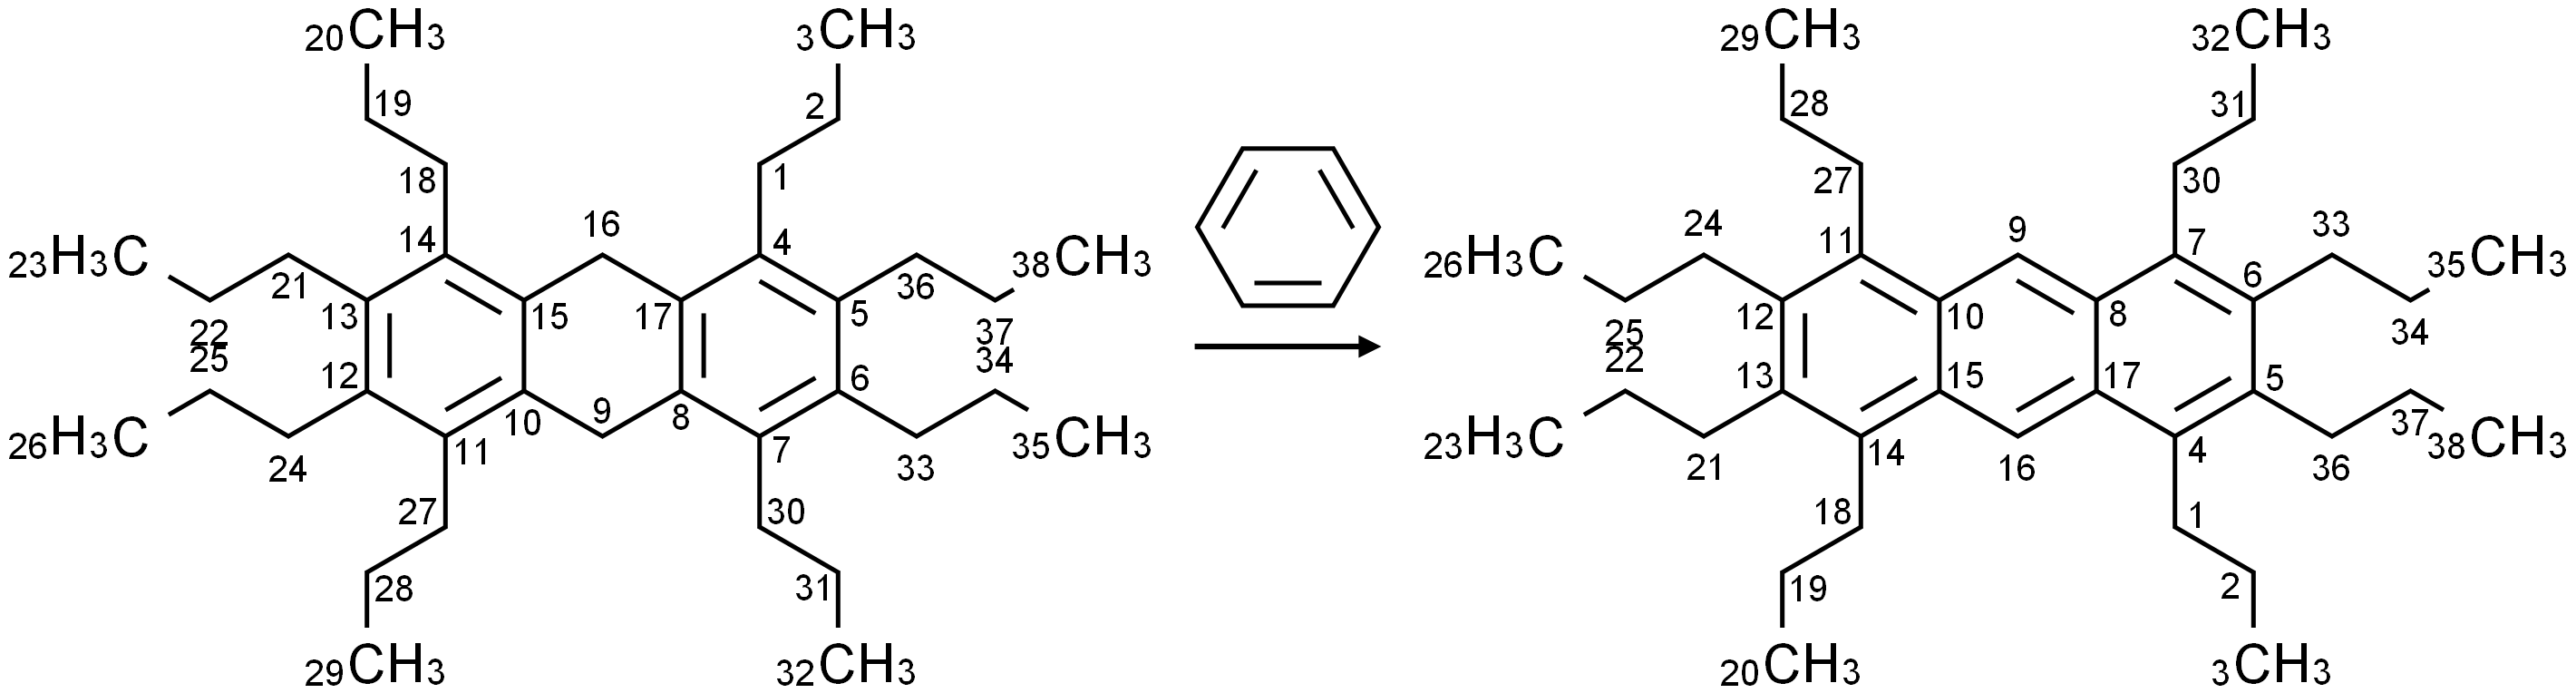

C:\Users\ergot\AppData\Local\Temp\ipykernel_25656\1252439731.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[c_ratio < 1.0]


Set size:         251
Patent:           US07901594B2
Reaction_id:      ord-8065783f97954cc58ed3954c39c8ddcd
After 2,3-dichloro-5,6-dicyanoquinone (0.100 g, 0.440 mmol) was added to a solution of 1,2,3,4,5,6,7,8-octapropyl-9,10-dihydroanthracene (0.208 g, 0.400 mmol) in benzene (5 ml), the mixture was refluxed for an hour with heating. The reaction mixture was filtered to remove hydroquinone and purified by silica gel column chromatography (ethyl acetate/hexane, 99/1) to give the title compound (0.164 g) as a white solid. The isolation yield was 79%.


In [46]:
# we can also safely drop hydrocarbon chemistry. It is not interesting for us
draw_reaction(df[c_ratio == 1.0])
df = df[c_ratio < 1.0]

In [47]:
# save results
df.to_pickle(f"{ORD_PATH}/uspto_rxn.pkl.zst")

# Inspect COMPOUNDS dataset

In [48]:
rxn = pd.read_pickle(f"{ORD_PATH}/uspto_rxn.pkl.zst")

In [49]:
%%time
df = pd.read_pickle(f"{ORD_PATH}/uspto_cmpd.pkl.zst")

CPU times: total: 6.05 s
Wall time: 6.06 s


In [50]:
%%time
# keep compounds from filtered reaction set
df = df.loc[rxn.index]

CPU times: total: 14.9 s
Wall time: 14.9 s


In [51]:
df

,trivial,name,smiles,rxn_role
ord-89aff4b1c18042e4bbb1f88ebba96f86,None,4-octyloxybenzoic acid chloride,C(CCCCCCC)OC1=CC=C(C(=O)Cl)C=C1,8
ord-89aff4b1c18042e4bbb1f88ebba96f86,( 1 ),p-n-octyloxybenzoic acid,C(CCCCCCC)OC1=CC=C(C(=O)O)C=C1,1
ord-89aff4b1c18042e4bbb1f88ebba96f86,None,p-octyloxybenzoic acid,C(CCCCCCC)OC1=CC=C(C(=O)O)C=C1,1
ord-89aff4b1c18042e4bbb1f88ebba96f86,None,thionyl chloride,S(=O)(Cl)Cl,1
ord-c218088b16c541088a933a7606f68c4c,None,p-decanoyloxybenzoic acid,C(CCCCCCCCC)(=O)OC1=CC=C(C(=O)O)C=C1,8
...,...,...,...,...
ord-055170a7c2ee464ba733ada95c7896b8,None,"(1R,5S)-7-{4-[2-(2,6-Dichloro-4-methyl-phenoxy...",C1(CC1)N(C(=O)C=1[C@H]2CNC[C@@H](CC1C1=CC=C(C=...,8
ord-055170a7c2ee464ba733ada95c7896b8,None,cyclopropyl-[5-(3-methoxy-propyl)-2-methyl-ben...,C1(CC1)NCC1=C(C=CC(=C1)CCCOC)C,1
ord-50ff38288a5a4316959b81c266f6f624,None,"(1R,5S)-7-{4-[2-(2,6-Dichloro-4-methyl-phenoxy...",C1(CC1)N(C(=O)C=1[C@H]2CNC[C@@H](CC1C1=CC=C(C=...,8
ord-50ff38288a5a4316959b81c266f6f624,None,"(1R,5S)-7-{4-[2-(2,6-dichloro-4-methyl-phenoxy...",C(C)(C)(C)OC(=O)N1C[C@H]2CC(=C([C@@H](C1)N2C(=...,1


In [52]:
df_na_vals(df)

trivial       ->      Missing values: 5390427 (88.82%)
name          ->      Missing values: 0 (0.00%)
smiles        ->      Missing values: 276492 (4.56%)
rxn_role      ->      Missing values: 0 (0.00%)


[]

### inspect missing smiles

In [53]:
df[df.smiles.isna()].name.value_counts()

solution                                    22930
ice water                                   16943
solid                                       11316
ice                                         10592
resultant mixture                            6971
                                            ...  
platinic chloride                               1
8-L                                             1
Tris(dibenzylideneacetone)palladium (0)         1
Tris (dibenzylideneacetone)palladium (0)        1
product ( IV )                                  1
Name: name, Length: 43471, dtype: int64

In [54]:
# REACTANT  1
# SOLVENT   3
# CATALYST  4
# WORKUP    5
# PRODUCT   8

df[df.smiles.isna() & (df.name == 'ice water')].rxn_role.value_counts()

1    15104
3     1837
4        1
8        1
Name: rxn_role, dtype: int64

In [55]:
idx = df[df.smiles.isna() & (df.name == 'ice water') & (df.rxn_role == 4)].index

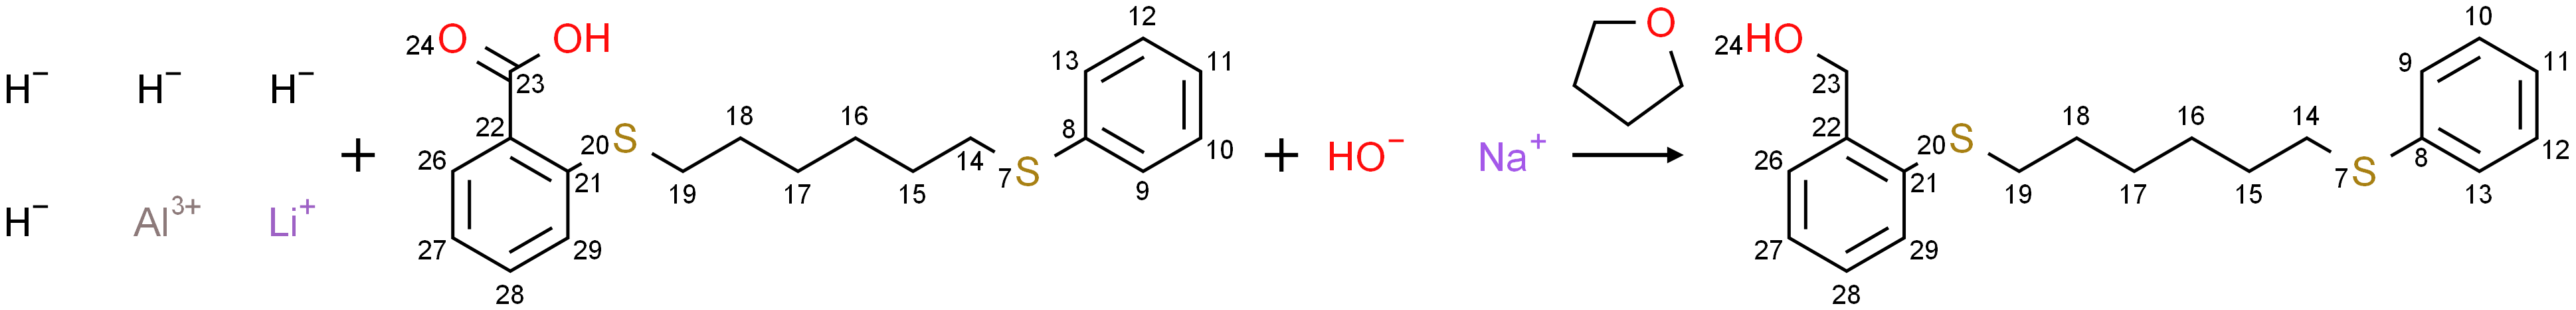

Set size:         1
Patent:           US05314918
Reaction_id:      ord-da7939a2978843b28f3e5a686a2e414c
To a suspension of lithium aluminum hydride (0.292 g, 0.007 mole) in tetrahydrofuran (30 ml) is added a solution of 2-(6-thiophenoxyhexylthio)benzoic acid (2.42 g, 0.007 mole) in tetrahydrofuran (30 ml). The reaction is stirred at room temperature under argon, overnight. When the reaction is complete several drops of ice water are added followed by cold 10% sodium hydroxide (approximately 1.0 ml), followed by cold 10% sodium hydroxide (approximately 1.0 ml), followed by more ice water. This produces a dry granular precipatate which is filtered and is washed. The filtrate is then dried over magnesium sulfate, filtered and is evaporated. The crude alcohol is flash chromatographed on silica gel to give the desired compound.


'ord-da7939a2978843b28f3e5a686a2e414c'

In [56]:
draw_reaction(rxn.loc[idx], highlight_text='ice water')

### Clean empty smiles
all non chemically-meaningful compounds, e.g. ```'solution', 'solid', 'resultant mixture', 'powder', 'crude material'```, with no smiles can be dropped. It is just parsing error. We keep 'ice water', 'ice', 'water' for the moment as it might indicate solvent or temperature.

In [57]:
empty_smi = df[df.smiles.isna()].name.value_counts()
empty_smi

solution                                    22930
ice water                                   16943
solid                                       11316
ice                                         10592
resultant mixture                            6971
                                            ...  
platinic chloride                               1
8-L                                             1
Tris(dibenzylideneacetone)palladium (0)         1
Tris (dibenzylideneacetone)palladium (0)        1
product ( IV )                                  1
Name: name, Length: 43471, dtype: int64

In [58]:
q = 0.99
print(empty_smi[empty_smi > empty_smi.quantile(q)].sum() / empty_smi.sum())
token_list = empty_smi[empty_smi > empty_smi.quantile(q)]
token_list

0.648720396973511


solution                                                               22930
ice water                                                              16943
solid                                                                  11316
ice                                                                    10592
resultant mixture                                                       6971
aqueous solution                                                        6195
TEA                                                                     5461
crude product                                                           4799
hexanes                                                                 3968
oil                                                                     3950
product                                                                 3436
resultant solution                                                      2822
hydrochloride salt                                                      2092

In [59]:
print(np.array2string(token_list.index.values, separator=',', max_line_width=10))

['solution',
 'ice water',
 'solid',
 'ice',
 'resultant mixture',
 'aqueous solution',
 'TEA',
 'crude product',
 'hexanes',
 'oil',
 'product',
 'resultant solution',
 'hydrochloride salt',
 'compound',
 'amine',
 'mixture',
 'ester',
 'acid chloride',
 'alcohol',
 'powder',
 'Grignard reagent',
 'petroleum ether',
 'polyphosphoric acid',
 'foam',
 'crude material',
 'EtOAc hexanes',
 'hexanes ethyl acetate',
 'methyl ester',
 'aldehyde',
 'amide',
 'ethyl acetate hexanes',
 'crystals',
 '4A',
 'stainless steel',
 'cuprous iodide',
 'suspension',
 'crude mixture',
 'catalyst',
 'liquid',
 'anhydride',
 'title compound',
 'SiO2',
 'Ice water',
 'three',
 'material',
 '( 1 )',
 'N,N-dimethylaminopyridine',
 'resultant suspension',
 'ketone',
 '( 100 )',
 'desired product',
 'acid',
 'residue',
 'white solid',
 '( a )',
 '( 2 )',
 'cuprous chloride',
 '( m )',
 'steel',
 'xylenes',
 'carboxylic acid',
 "N,N'-carbonyldiimidazole",
 'diazonium salt',
 '( s )',
 'Teflon',
 'crude residue',

In [60]:
drop_list = [
            'solution',
            # 'ice water',
            'solid',
            # 'ice',
            'resultant mixture',
            # 'aqueous solution',
            # 'TEA',
            'crude product',
            # 'hexanes',
            'oil',
            'product',
            'resultant solution',
            # 'hydrochloride salt',
            'compound',
            # 'amine',
            'mixture',
            # 'acid chloride',
            # 'ester',
            # 'alcohol',
            # 'hexanes ethyl acetate',
            'powder',
            # 'polyphosphoric acid',
            # 'Grignard reagent',
            # 'EtOAc hexanes',
            # 'petroleum ether',
            'crude material',
            # 'amide',
            'foam',
            # 'methyl ester',
            # 'EtOAc-hexanes',
            # 'ethyl acetate hexanes',
            # 'aldehyde',
            '4A',
            # 'cuprous iodide',
            'stainless steel',
            'material',
            'crystals',
            'crude mixture',
            'liquid',
            'suspension',
            'catalyst',
            'three',
            # 'anhydride',
            'title compound',
            'resultant suspension',
            'SiO2',
            # 'Ice water',
            # 'ketone',
            # 'N,N-dimethylaminopyridine',
            '( a )',
            # 'dimethyl acetal',
            # 'cuprous chloride',
            '( 1 )',
            'steel',
            'residue',
            # 'xylenes',
            # 'acid',
            'desired product',
            '( 100 )',
            # 'diazonium salt',
            'white solid',
            # 'carboxylic acid',
            # 'ethyl ester',
            '3A',
            '( 2 )',
            # 'resin',
            'Teflon',
            # 'base',
            'crude residue',
            # 'IMS',
            'II',
            '10',
            '( m )',
            'raw materials',
            # 'stannous chloride dihydrate',
            # 'imine',
            # "N,N'-carbonyldiimidazole",
            'saturated aqueous solution',
            '( 3 )',
            # 'Hexanes',
            # 'stannous chloride',
            'saturated solution',
            # 'solvent',
            '( b )',
            '( 5 )',
            # 'tetrakistriphenylphosphine palladium',
            # 'Mg',
            # 'CuBr',
            '( s )',
            # 'NaIO4',
            '3','1',
            'glass',
            'intermediate',
            # 'cuprous cyanide',
            # 'hydrate',
            # '4-N,N-dimethylaminopyridine',
            # 'peroxide',
            '( 4 )',
            # 'N,N′-carbonyldiimidazole',
            # 'NH4OAc',
            # 'ferric chloride',
            # 'Na',
            # 'ice H2O',
            # 'N-Aryl-benzenesulfonamides',
            # 'water ice',
            # 'hexanes EtOAc',
            '( c )',
            # 'NaH2PO4',
            'reagent',
            'gum',
            '2','20',
            'teflon',
            # 'nitrile',
            # 'alkyne',
            # 'reduced iron',
            # 'oxime',
            # 'monohydrate',
            '( g )',
            '( w )',
            # 'diol',
            'Intermediate 1',
            'starting material',
            # 'fumarate salt',
            'Heterocyclic',
            # 'EtOAc Hexanes',
            # 'stannic chloride',
            # 'nitro',
            # 'mercuric chloride',
            # 'esters',
            '( I )',
            # 'KHCO3',
            # 'LiOH monohydrate',
            # 'polystyrene',
            'yellow solid',
            '( A )',
            'solids',
            # 'amides',
            '15',
            '( 6 )',
            # 'Na2S2O5',
            # 'mercuric acetate',
            'final mixture',
            # 'Ice',
            # 'amino acid',
            '( d )',
            # 'FeCl3',
            # 'ice-salt',
            # 'tetrakis(triphenyl-phosphine)palladium',
            # 'cuprous bromide',
            '50',
            'paraffin',
            # 'epoxide',
            # 'diamine',
            # 'triethylamine-2HF',
            # '1,1-carbonyldiimidazole',
            '( 8 )',
            # 'ethanolic solution',
            # 'mercuric oxide',
            'III',
            'raw material',
            '( 9 )',
            '12',
            'desired material',
            # 'methanolic solution',
            # 'PdCl2dppf',
            # 'peptide',
            'title compounds',
            'salt',
            # 'palladium tetrakistriphenylphosphine',
            '1-L',
            'free base',
            '( 7 )',
            '30',
            # 'diazonium',
            # 'acetate salt',
            # 'diethyl ester',
            '10/1',
            # 'potassium tert.-butylate',
            # 'olefin',
            'Intermediate 2',
            # 'CsCO3',
            'crystal',
            'one',
            # 'cuprous oxide',
            # 'sulfonamide',
            '( 10 )',
            # 'secondary amine',
            'Example 1',
            'two',
            '4',
            'eluent',
            # 'N,N-dicyclohexylcarbodiimide',
            # 'ethyl acetate petroleum ether',
            # 'ceric ammonium nitrate',
            '40',
            # 'Amine',
            'Compound II',
            '( B )',
            # 'CrO3',
            '100',
            # 'thiol',
            # 'cupric acetate',
            'complex',
            # 'petroleum ether ethyl acetate',
            'IV',
            'atmosphere',
            '2-L',
            # 'amines',
            # 'oxide',
            'step-ii',
            'four',
            'E1',
            'desired compound',
            # 'acyl chloride',
            '( II )',
            'crude compound',
            # 'triethyl phosphonoacetate',
            'resultant product',
            'Heterocycles',
            # 'CuSO4.5H2O',
            # 'ethylene ketal',
            'Intermediate 6',
            'crude intermediate',
            # 'ethyl acetate-hexanes',
            # 'acetal',
            'solution A',
            # 'ammonium salt',
            # 'aq. solution',
            # 'oxalate salt',
            # '2B',
            # '5,6-dihydrospiro[benzo[1,2-b:5,4-b′]difuran-3,3′-indol]-2″(1′H)-one',
            # 'Cu',
            # 'alcohols',
            '1h',
            # 'ice hydrochloric acid',
            # 'tertiary amine',
            'desired intermediate',
            '1a',
            # 'heptanes',
            # 'ferrous sulfate',
            # 'Hexanes EtOAc',
            '( 15 )',
            '9',
            # 'cupric chloride',
            'ArH',
            '11',
            # 'pinacol ester',
            '21',
            'title material',
            # 'Pd(Ph3)4',
            'D4',
            'Intermediate 4',
            'amino',
            # 'tetrakistriphenylphosphine palladium(0)',
            'DNA',
            '60',
            # 'diethyl acetal',
            'compound 1',
            # 'SeO2',
            # 'Cu2O',
            # 'industrial methylated spirit',
            'mixed solvent',
            'dihydrobromide',
            # 'tetrakistriphenylphosphine palladium (0)',
            'crude solution',
            # 'amino acids',
            # 'TiCl3',
            'pure product',
            'Intermediate 14',
            'PTFE',
            '2h',
            # 'HClO4',
            'A1',
            '( 12 )',
            # 'Na2HPO4',
            # 'dioxanes',
            # 'sulfonic acid',
            # 'di-TFA',
            'white crystals',
            'E2',
            'trihydrochloride',
            # 'CuCl2',
            'polymer',
            'formula II',
            '1L',
            # 'Boc',
            '13',
            'stock solution',
            # 'CeCl3',
            # 'carboxylic acids',
            # 'H+',
            # 'TBF',
            # 'Ag2O',
            # 'CO3',
            'R3—(CH2)m—NH2',
            '( 11 )',
            # 'Petroleum ether',
            'intermediate 27',
            # 'SO2Cl2',
            '1E',
            '( i )',
            '( C )',
            '25',
            'Solution A',
            'mixed solution',
            'hydrobromide salt',
            '14',
            'resultant residue',
            'Amine-1',
            'Intermediate 12',
            'bromo',
            # 'potassium t-butylate',
            'needles',
            'Intermediate 5',
            # 'enolate',
            # 'carbonyl',
            # 'Pt',
            # 'SnCl2 dihydrate',
            'quartz',
            # 'tetrakis-(triphenylphosphine)palladium',
            'Intermediate 3',
            '5-L',
            'example 1 ( b )',
            '( E )-',
            # 'hydrocarbon',
            # 'ice methanol',
            # 'ferric chloride hexahydrate',
            # 'diacid',
            # 'halogen',
            # 'crude acid',
            '18',
            'same solvent',
            'C2',
            'molar solution',
            'starch',
            '( 20 )',
            '17',
            # 'hydrazone',
            # 'Ti(OEt)4',
            '( ii )',
            # 'K3PO4.3H2O',
            '( 1H )',
            '0C',
            # 'Pd[PPh3]4',
            # 'ferrous chloride tetrahydrate',
            'chloro',
            # 'tetrakis (triphenylphosphine)palladium(0)',
            '( M )',
            # 'alkoxide',
            '1-a',
            # 'pyridinium bromide perbromide',
            '( 14 )',
            # 'magnesium salt',
            '2L',
            'target compound',
            'orange oil',
            'final product',
            'intermediate 1',
            '2A',
            '( III )',
            # 'Cu(I)I',
            # 'FeSO4.7H2O',
            '2C',
            # 'tetrakis triphenylphosphine palladium',
            'Formula III',
            '1/1',
            '200',
            'D1',
            'colorless oil',
            'diazo',
            'formula III',
            # 'PdC',
            # 'Pd--C',
            # 'polyester',
            # 'lactone',
            'VI','5',
            # 'hydrazide',
            # 'Na2SO4.10H2O',
            # 'glycol',
            'Solvent B',
            # 'primary amine',
            # 'NaHB(OAc)3',
            '6',
            '( 13 )',
            'Intermediate 7',
            'buffer solution',
            # 'N-oxide',
            '1A',
            # 'potassium osmate dihydrate',
            '( 18 )',
            '( 16 )',
            # 'halide',
            # 'diester',
            # 'zeolite',
            # 'ice acetone',
            'Intermediate 100',
            # 'hexanes ether',
            # 'carbamates',
            # 'ether-hexane',
            # 'petroleum ether EtOAc',
            'beige solid',
            # 'PdCl2(dppf)-CH2Cl2Adduct',
            # 'Amide',
            # 'sulfuric acid ester',
            # 'PdCl2(dppf)CH2Cl2',
            # 'Hastelloy',
            '( 19 )',
            'yellow oil',
            # 'ammonium sulfide',
            # 'azoisobutyronitrile',
            'Example 1 ( i )',
            # 'butyl ester',
            'final solution',
            '3h',
            'Intermediate 9',
            'syrup',
            '16',
            'compound 5',
            '3R',
            'crude oil',
            '2-N',
            'ion',
            # 'dihydrate',
            'Example 1 ( a )',
            '( E )',
            # 'polyethylene glycol',
            # 'RuCl3',
            # 'dimethyl ester',
            # '2-Me THF',
            'reaction mixture',
            # 'tetrakis(triphenyl-phosphine)palladium(0)',
            # 'Aqueous solution',
            # 'ferrous sulfate heptahydrate',
            'tricyclic bromide',
            # '4-nitrophenylchloroformate',
            '70',
            '5a',
            # 'acyloxyalkyl carbamates',
            'polyol',
            # 'hemihydrate',
            # 'aqueous saturated solution',
            # 'ether hexanes',
            # 'Ba(OH)2',
            # 'dichlorobis(triphenylphosphine) palladium (II)',
            # 'sulfone',
            '( D )',
            # "N,N'-Carbonyldiimidazole",
            # 'ion-exchanged',
            'alkyl',
            '1c',
            # 'ice NaCl',
            # 'enamine',
            # 'dimaleate',
            'off-white solid',
            '3-L',
            # 'EtOAc petroleum ether'
]

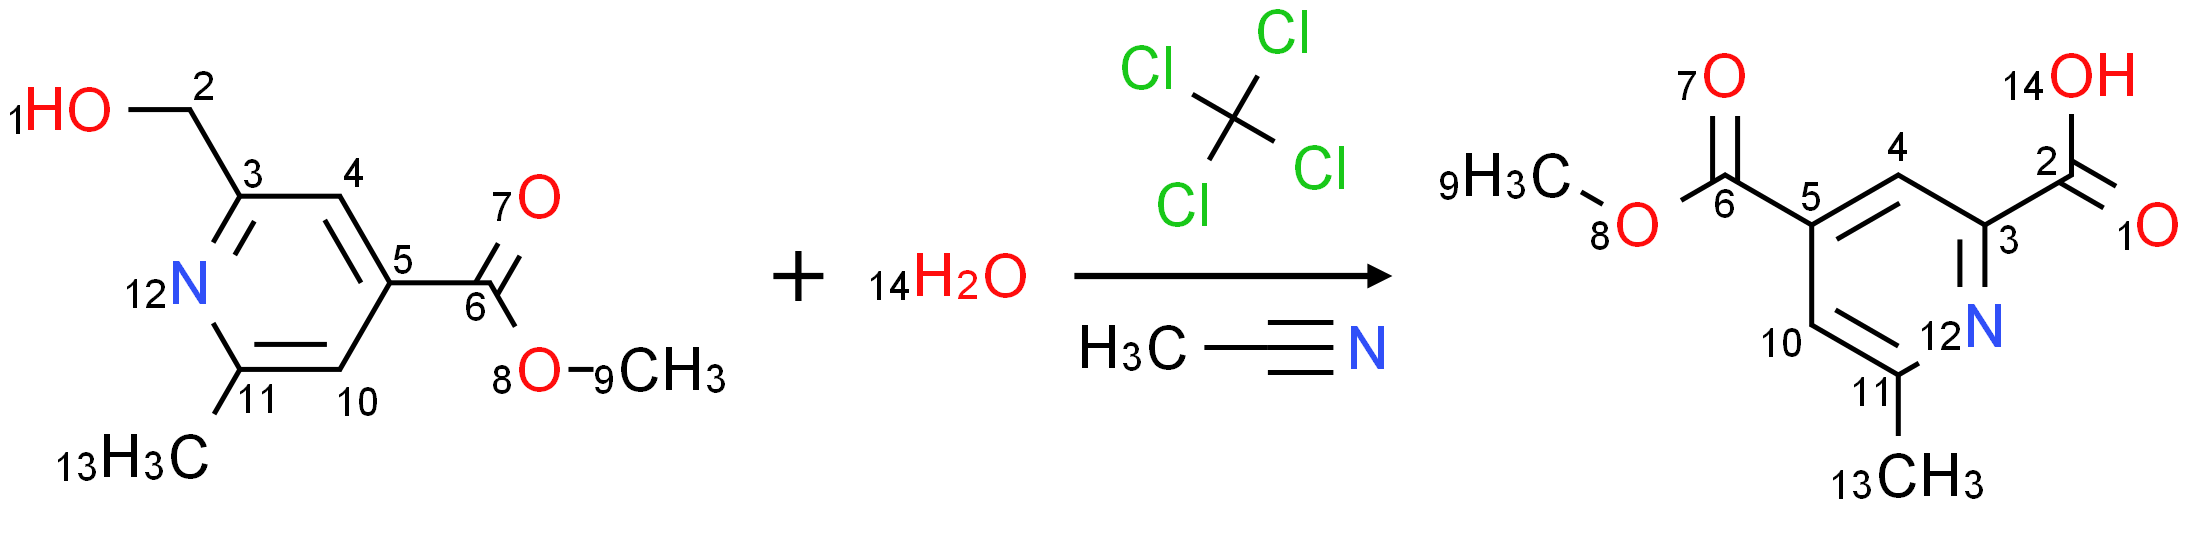

Set size:         55
Patent:           US08299267B2
Reaction_id:      ord-f91391d1d47a4f2585035374b1b5e68e
To a stirring mixture of 51.6 mg (0.283 mmol) of methyl 2-(hydroxymethyl)-6-methylisonicotinate in 1.6 mL of CCl4, 1.6 mL of CH3CN, and 2.4 mL of H2O was added 348 mg (1.63 mmol) of NaIO4, and 8.8 mg (0.0424 mmol) of RuCl3.(H2O)n. After 2 h, 6 mg of RuCl3.(H2O)n was added, and after 2.5 h the mixture was filtered through Celite twice with EtOAc and MeOH. The solution was concentrated and then reconcentrated with MeOH (2×) to remove H2O. Crude 4-(methoxycarbonyl)-6-methylpicolinic acid was used in the next reaction without further purification.


'ord-f91391d1d47a4f2585035374b1b5e68e'

In [61]:
token = 'RuCl3'
idx = df[df.smiles.isna() & (df.name == token)].index
draw_reaction(rxn.loc[idx], highlight_text=token)

In [62]:
drop_list

['solution',
 'solid',
 'resultant mixture',
 'crude product',
 'oil',
 'product',
 'resultant solution',
 'compound',
 'mixture',
 'powder',
 'crude material',
 'foam',
 '4A',
 'stainless steel',
 'material',
 'crystals',
 'crude mixture',
 'liquid',
 'suspension',
 'catalyst',
 'three',
 'title compound',
 'resultant suspension',
 'SiO2',
 '( a )',
 '( 1 )',
 'steel',
 'residue',
 'desired product',
 '( 100 )',
 'white solid',
 '3A',
 '( 2 )',
 'Teflon',
 'crude residue',
 'II',
 '10',
 '( m )',
 'raw materials',
 'saturated aqueous solution',
 '( 3 )',
 'saturated solution',
 '( b )',
 '( 5 )',
 '( s )',
 '3',
 '1',
 'glass',
 'intermediate',
 '( 4 )',
 '( c )',
 'reagent',
 'gum',
 '2',
 '20',
 'teflon',
 '( g )',
 '( w )',
 'Intermediate 1',
 'starting material',
 'Heterocyclic',
 '( I )',
 'yellow solid',
 '( A )',
 'solids',
 '15',
 '( 6 )',
 'final mixture',
 '( d )',
 '50',
 'paraffin',
 '( 8 )',
 'III',
 'raw material',
 '( 9 )',
 '12',
 'desired material',
 'title compounds'

In [63]:
%%time
mask = ~df.name.isin(drop_list)
mask.sum()

CPU times: total: 969 ms
Wall time: 968 ms


5974025

In [64]:
%%time
df = df[mask]

CPU times: total: 812 ms
Wall time: 794 ms


In [65]:
df_na_vals(df)

trivial       ->      Missing values: 5295810 (88.65%)
name          ->      Missing values: 0 (0.00%)
smiles        ->      Missing values: 181879 (3.04%)
rxn_role      ->      Missing values: 0 (0.00%)


[]

In [66]:
# save cleaned version
df.to_pickle(f'{ORD_PATH}/uspto_cmpd.pkl.zst')

Total occurencies: 4


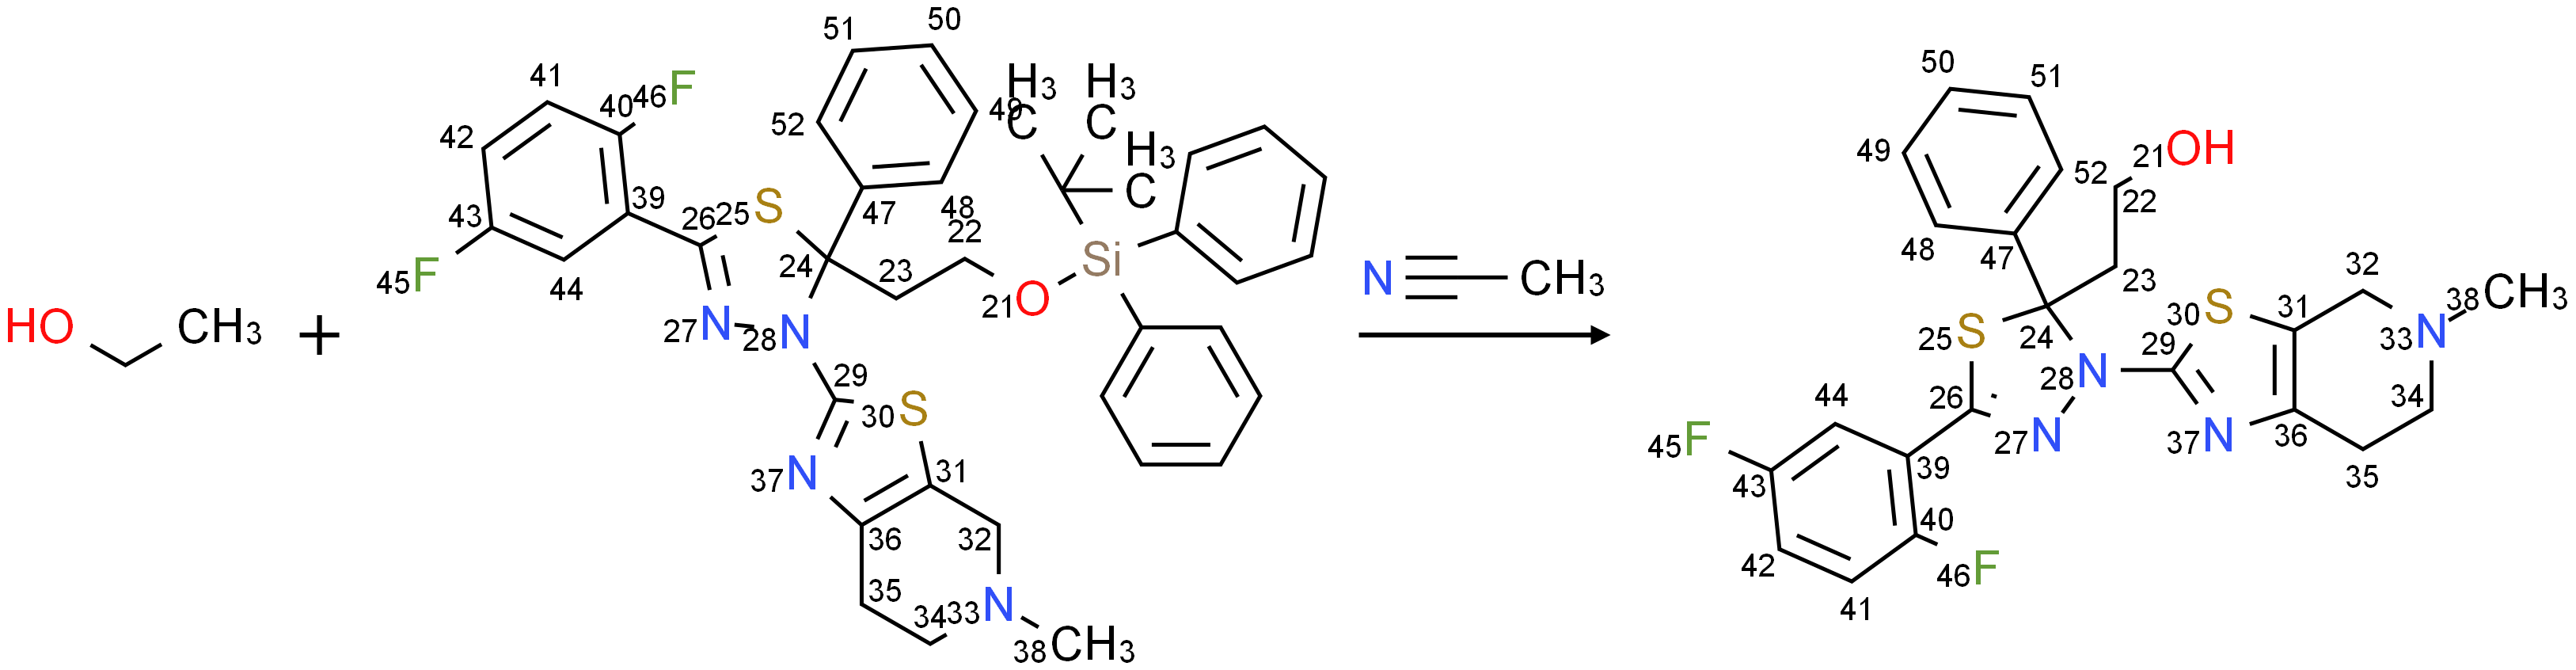

Set size:         4
Patent:           US08268871B2
Reaction_id:      ord-99edb586463d4afea72f9388ac8830fc
Preparation of 245-(2,5-difluorophenyl)-3-(5-methyl-4,5,6,7-tetrahydrothiazolo[5,4-c]pyridin-2-yl)-2-phenyl-2,3-dihydro-1,3,4-thiadiazol-2-yl)ethanol: To a solution of 2-(2-(2-(tert-butyldiphenylsilyloxy)ethyl)-5-(2,5-difluorophenyl)-2-phenyl-1,3,4-thiadiazol-3(2H)-yl)-5-methyl-4,5,6,7-tetrahydrothiazolo[5,4-c]pyridine (0.070 g, 0.098 mmol) in 2 mL of anhydrous acetonitrile was added HF-TEA (0.160 mL, 0.99 mmol). The solution was stirred at room temperature for 16 hours then slowly quenched with saturated NaHCO3 (20 mL). The mixture was extracted with EtOAc (3×10 mL) and the combined organic phases were washed with brine (10 mL), dried over Na2SO4 and concentrated in vacuo. The residue was purified by flash column chromatography (0-1% MeOH/DCM) and the residue was dissolved in 2 mL of methanol and treated with 1N HCl/MeOH (2 mL). After stirring for 10 minutes, the solution was conc

'ord-99edb586463d4afea72f9388ac8830fc'

In [67]:
#TODO fix 'HF-TEA' token interpreted as 'TEA' only
idx = rxn.notes.str.contains(' HF-TEA')
print("Total occurencies:", idx.sum())
draw_reaction(rxn.loc[idx], highlight_text='HF-TEA')